<a href="https://colab.research.google.com/github/fernandoGitHub/ML_Projects/blob/main/Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autonomous Driving - Car Detection

Many of the ideas in this notebook are described in the two YOLO papers: [Redmon et al., 2016](https://arxiv.org/abs/1506.02640) and [Redmon and Farhadi, 2016](https://arxiv.org/abs/1612.08242). 

**By the end of this assignment, you'll be able to**:

- Detect objects in a car detection dataset
- Implement non-max suppression to increase accuracy
- Implement intersection over union
- Handle bounding boxes, a type of image annotation popular in deep learning

## Table of Contents

- [Packages](#0)
- [1 - Problem Statement](#1)
- [2 - YOLO](#2)
    - [2.1 - Model Details](#2-1)
    - [2.2 - Filtering with a Threshold on Class Scores](#2-2)
        - [Exercise 1 - yolo_filter_boxes](#ex-1)
    - [2.3 - Non-max Suppression](#2-3)
        - [Exercise 2 - iou](#ex-2)
    - [2.4 - YOLO Non-max Suppression](#2-4)
        - [Exercise 3 - yolo_non_max_suppression](#ex-3)
    - [2.5 - Wrapping Up the Filtering](#2-5)
        - [Exercise 4 - yolo_eval](#ex-4)
- [3 - Test YOLO Pre-trained Model on Images](#3)
    - [3.1 - Defining Classes, Anchors and Image Shape](#3-1)
    - [3.2 - Loading a Pre-trained Model](#3-2)
    - [3.3 - Convert Output of the Model to Usable Bounding Box Tensors](#3-3)
    - [3.4 - Filtering Boxes](#3-4)
    - [3.5 - Run the YOLO on an Image](#3-5)
- [4 - Summary for YOLO](#4)
- [5 - References](#5)

# 1 - Packages & Setup

In [1]:
import argparse
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import PIL

import imghdr
import colorsys
import random

import shutil

from functools import reduce

#from matplotlib.pyplot import imshow

import scipy.io
import scipy.misc

#from PIL import ImageFont, ImageDraw, Image
#from PIL import Image, ImageDraw, ImageFont
#from tensorflow.keras import backend as K

import tensorflow as tf
import tensorflow.keras.backend as tfK
from tensorflow.python.framework.ops import EagerTensor

import tensorflow.keras.models as tfm

#from tensorflow.keras.models import load_model
#import utils

#from utils.py import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image

%matplotlib inline

In [2]:
# Installing packages without !pip
import sys
import subprocess as sp
import pkg_resources

def install_package(package, reload = True):
  # Veryfing existing install prior to install
  if is_installed(package):
    print (f'Package: {package} is already installed. Skipping installation')
  else:
    print(f'Installing {package} ...')
    sp.check_call([sys.executable, '-m', 'pip', 'install', package])
    print(f'Package {package} has been successfully installed')

  if reload:
    reload_packages()

def is_installed (package):
  # Getting all the list of packages
  return (package in get_installed_packages())

def get_installed_packages():
  return sorted({pkg.key for pkg in pkg_resources.working_set})

def reload_packages():
  print ('Reloading Packages')
  import pkg_resources
  import importlib
  importlib.reload(pkg_resources)

In [3]:
install_package('wget')
import wget

#!pip install -Uqq ipdb
install_package('ipdb')
import ipdb
%pdb on

Package: wget is already installed. Skipping installation
Reloading Packages
Package: ipdb is already installed. Skipping installation
Reloading Packages
Automatic pdb calling has been turned ON


In [4]:
# Copying data from Github to session
_MODEL_DATA_DIR = './model_data'
_MODEL_FILES = ['anchors.txt', 'coco_classes.txt', 'pascal_classes.txt', 'saved_model.pb', 'yolo_anchors.txt']
_GITHUB_DIR_URL = 'https://github.com/fernandoGitHub/ML_Projects/raw/main/Yolo/data/'

# Remove default sample_data directory
if os.path.isdir('./sample_data'):
  shutil.rmtree('./sample_data')
  print('Removing default sample_data directory...')

if os.path.isdir(_MODEL_DATA_DIR):
  shutil.rmtree(_MODEL_DATA_DIR)
  print(f'Removing old {_MODEL_DATA_DIR} directory...')
os.makedirs(_MODEL_DATA_DIR)

for file in _MODEL_FILES:
  _FILE_PATH = os.path.join(_MODEL_DATA_DIR, file)
  if not os.path.isfile(_FILE_PATH):
    _URL_PATH = os.path.join(_GITHUB_DIR_URL, file)
    file_name = wget.download(_URL_PATH)
    print(f"Fetching from GitHub: {file} ...")
    os.replace(os.path.join('.', file), _FILE_PATH)

Removing old ./model_data directory...
Fetching from GitHub: anchors.txt ...
Fetching from GitHub: coco_classes.txt ...
Fetching from GitHub: pascal_classes.txt ...
Fetching from GitHub: saved_model.pb ...
Fetching from GitHub: yolo_anchors.txt ...


In [5]:
# Enabling Multi-output on Notebook cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 2 - Utilities

In [6]:
BOLD_ON ='\033[1m'
BOLD_OFF='\033[0m'
def print_bold(text):
  print(BOLD_ON+text+BOLD_OFF)

In [7]:
def render_image(image, image_name='Unspecified', display_text=True):
  """
  render_image plots the image values as well as each one of its channels
  using pseudocolors

  Arguments:
    image - a (HxWx3) array
    image_name - str containing the name of the image (default: Unspecified)
    display_text (default: True)
  """

  min_value =  str(np.round(np.min(image), 3))
  max_value =  str(np.round(np.max(image), 3))
  mean_value = str(np.round(np.mean(image), 3))
  print_bold(f'Image name: {image_name} - Image shape: {image.shape} - (min, max, mean) = ({min_value}, {max_value}, {mean_value})\n')

  fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,8))
  ax[0].imshow(image)
  ax[0].set_title('RGB channels')
  ax[1].imshow(image[:, :, 0])
  ax[1].set_title('R channel')
  ax[2].imshow(image[:, :, 1])
  ax[2].set_title('G channel')
  ax[3].imshow(image[:, :, 2])
  ax[3].set_title('B channel')
  plt.show()
  print('\n')

In [8]:
help(render_image)

Help on function render_image in module __main__:

render_image(image, image_name='Unspecified', display_text=True)
    render_image plots the image values as well as each one of its channels
    using pseudocolors
    
    Arguments:
      image - a (HxWx3) array
      image_name - str containing the name of the image (default: Unspecified)
      display_text (default: True)



In [63]:
def preprocess_image(img_path, model_image_size, render=True):
  """
  preprocess_image(img_path, model_image_size)
  does something that I want to find out
  Returns:
    image - A PIL image object
    image_data - A ndarray of size (1, H x W x 3)
    render - Boolean for calling render_image (default: True)
  """

  image_type = imghdr.what(img_path)

  image = PIL.Image.open(img_path)
  resized_image = image.resize(tuple(reversed(model_image_size)), PIL.Image.BICUBIC)
  image_data = np.array(resized_image, dtype='float32')
  image_data /= 255.
 
  if render:
    render_image(image_data, image_name=str(img_path).split("/")[-1], display_text=True)

  image_data = np.expand_dims(image_data, axis=0)

  return resized_image, image_data, image_type

In [10]:
help(preprocess_image)

Help on function preprocess_image in module __main__:

preprocess_image(img_path, model_image_size, render=True)
    preprocess_image(img_path, model_image_size)
    does something that I want to find out
    Returns:
      image - A PIL image object
      image_data - A ndarray of size (1, H x W x 3)
      render - Boolean for calling render_image (default: True)



Image name: image-placeholder-title.jpg - Image shape: (1024, 1024, 3) - (min, max, mean) = (0.0, 0.984, 0.491)



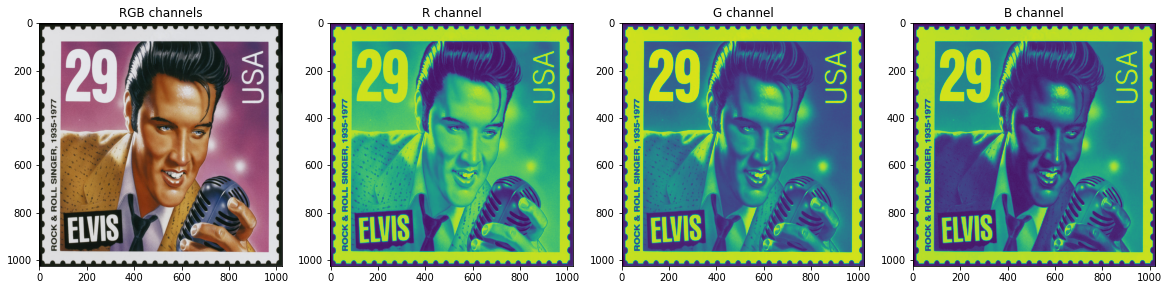



TYPES 	image: <class 'PIL.JpegImagePlugin.JpegImageFile'> 	 image_data: <class 'numpy.ndarray'> 	 image_type: <class 'str'>
image_type: jpeg


In [50]:
# UNITEST PREPROCESS_IMAGE
img_path = './image-placeholder-title.jpg'
model_image_size = (512*2, 512*2)

image, image_data, image_type = preprocess_image(img_path=img_path, model_image_size=model_image_size, render=True)

print(f'TYPES \timage: {type(image)} \t image_data: {type(image_data)} \t image_type: {type(image_type)}')
print(f'image_type: {image_type}')

In [12]:
# Reading classes and anchors from file
def read_classes(classes_path):
  """
  Reads a list of classes from a file

  Attributes:
  classes_path - string including the path to the file

  Returns:
  A list of strings (without spaces) including the names of the classes
  """

  with open(classes_path) as f:
    class_names = f.readlines()
  
  class_names = [c.strip() for c in class_names]  
  return class_names
  

def read_anchors(anchors_path):
  """
  Reads a list of anchors from a file
  Anchors sizes should be defined from 0 to 1

  Attributes:
  anchors_path - string including the path to the file

  Returns:
  A 2 columns ndarray with the size of the boxes
  """
  
  with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    
  anchors = np.array(anchors).reshape(-1, 2)
  return anchors

In [13]:
help(read_classes)

help(read_anchors)

Help on function read_classes in module __main__:

read_classes(classes_path)
    Reads a list of classes from a file
    
    Attributes:
    classes_path - string including the path to the file
    
    Returns:
    A list of strings (without spaces) including the names of the classes

Help on function read_anchors in module __main__:

read_anchors(anchors_path)
    Reads a list of anchors from a file
    Anchors sizes should be defined from 0 to 1
    
    Attributes:
    anchors_path - string including the path to the file
    
    Returns:
    A 2 columns ndarray with the size of the boxes



In [14]:
# UNITEST FOR LOAD DATA
class_names = read_classes(classes_path='./model_data/pascal_classes.txt')
print(f'Lenght: {len(class_names)} \t Type: {type(class_names)} \t')
print(f'Element[0]: {class_names[0]} \t Type: {type(class_names[0])}')
print('\n')

anchors = read_anchors(anchors_path='./model_data/anchors.txt')
print(f'Shape: {anchors.shape} \t Type: {type(anchors)} \t')
print(f'Elements[0,:]: {anchors[0,:]} \t Type: {type(anchors[0][0])}')

Lenght: 20 	 Type: <class 'list'> 	
Element[0]: aeroplane 	 Type: <class 'str'>


Shape: (5, 2) 	 Type: <class 'numpy.ndarray'> 	
Elements[0,:]: [0.57273  0.677385] 	 Type: <class 'numpy.float64'>


In [15]:
# Boxes related functions
def scale_boxes(boxes, image_shape):
  """ Scales the predicted boxes in order to be drawable on the image"""
  height = float(image_shape[0])
  width = float(image_shape[1])
  image_dims = K.stack([height, width, height, width])
  image_dims = K.reshape(image_dims, [1, 4])
  boxes = boxes * image_dims
  return boxes

In [16]:
# UNITEST FOR SCALE_BOXES


In [17]:
def get_colors_for_classes(num_classes):
  """
  Returns a list of random colors for number of classes given.
  The function has memory, so colors will only recalculate when 
  the number of classes changes.

  Attributes:
  - num_classes (int)

  Returns:
    - A list of 3 colors tuples (0-255, 0-255, 0-255)
  """
  
  # Use previously generated colors if num_classes is the same.
  if (hasattr(get_colors_for_classes, "colors") and len(get_colors_for_classes.colors) == num_classes):
    return get_colors_for_classes.colors

  hsv_tuples = [(x / num_classes, 1., 1.) for x in range(num_classes)]
  colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
  colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

  # Fixed seed for consistent colors across runs.
  random.seed(10101)

  # Shuffle colors to decorrelate adjacent classes.
  random.shuffle(colors)

  # Reset seed to default.
  random.seed(None)

  # Save colors for future calls.
  get_colors_for_classes.colors = colors  

  return colors

In [18]:
# UNITEST FOR GET_COLORS_FOR_CLASSES
colors = get_colors_for_classes(5)
print(colors)

# Verify it returns the same colors is number of classes hasn't changed
assert colors == get_colors_for_classes(5), 'The function should keep the same colors'

# Calculating new colors
colors = get_colors_for_classes(8)
print(colors)

[(255, 0, 0), (204, 0, 255), (0, 102, 255), (0, 255, 102), (203, 255, 0)]
[(127, 0, 255), (255, 0, 0), (255, 191, 0), (255, 0, 191), (0, 63, 255), (127, 255, 0), (0, 255, 255), (0, 255, 63)]


In [85]:
from PIL import ImageFont, ImageDraw

def draw_boxes(image, boxes, box_classes, class_names, scores=None):
  """
  Draw bounding boxes with class name and optional box score on image.

  Arguments:
    image: An `array` of shape (width, height, 3) with values in [0, 1].
    boxes: An `array` of shape (num_boxes, 4) containing box corners as
        (y_min, x_min, y_max, x_max).
    box_classes: A list of indices into `class_names`.
    class_names: A list of string class names.
    scores: A list of scores for each box.

  Returns:
      A copy of the image modified with given bounding boxes.
  """

  # Calculating Font Size
  min_font_size = 60
  width, height = image.size
  fontsize = int(min(min_font_size, min(width, height)/10))
  font = ImageFont.truetype('arial', fontsize)
   
  # Calculating box thickness as function of size in pixels
  thickness = (image.size[0] + image.size[1]) // 300

  # Getting array of colors
  colors = get_colors_for_classes(len(class_names))

  for i, c in list(enumerate(box_classes)):
    box_class = class_names[c]
    box = boxes[i]
    
    if isinstance(scores.numpy(), np.ndarray):
      score = scores.numpy()[i]
      label = '{} {:.2f}'.format(box_class, score)
    else:
      label = '{}'.format(box_class)

    draw = ImageDraw.Draw(image)
    label_size = draw.textsize(label, font)

    top, left, bottom, right = box
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
    right = min(image.size[0], np.floor(right + 0.5).astype('int32'))

    if top - label_size[1] >= 0:
      text_origin = np.array([left, top - label_size[1]])
    else:
      text_origin = np.array([left, top + 1])

    for j in range(thickness):
      draw.rectangle([left + j, top + j, right - j, bottom - j], outline=colors[c])
    draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
 
    draw.text(tuple(text_origin), label, fill='black', font=font)
    del draw

  image_data = np.array(image)

  return image, image_data

Image name: Altered image - Image shape: (1024, 1024, 3) - (min, max, mean) = (0, 255, 124.136)



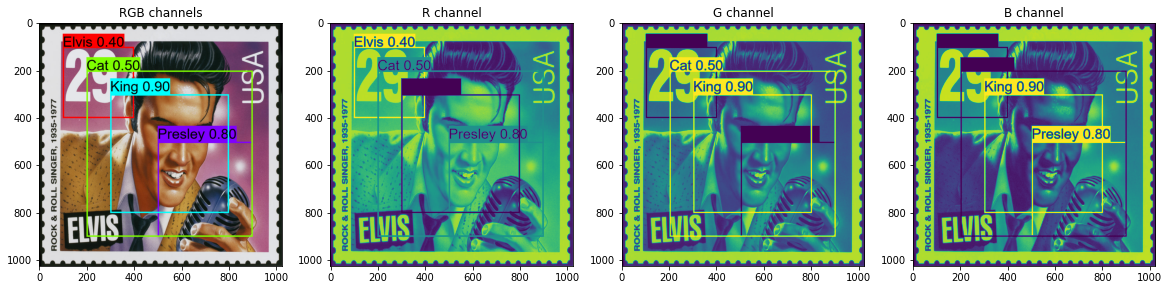

In [86]:
# UNITEST FOR DRAW BOXES
boxes = [[100, 100, 400, 400], [500, 500, 900, 900], [300, 300, 800, 800], [200, 200, 900, 900]]
box_classes = [0, 1, 2, 3]
class_names = ['Elvis', 'Presley', 'King', 'Cat']
scores = tf.constant([0.4, 0.8, 0.9, 0.5])

image, image_data, image_type = preprocess_image(img_path=img_path, model_image_size=model_image_size, render=False)
new_image, new_image_data = draw_boxes(image=image, boxes=boxes, box_classes=box_classes, class_names=class_names, scores=scores)
render_image(image=new_image_data, image_name='Altered image')

In [26]:
def compose(*funcs):
    """Compose arbitrarily many functions, evaluated left to right.

    Reference: https://mathieularose.com/function-composition-in-python/
    """
    # return lambda x: reduce(lambda v, f: f(v), funcs, x)
    if funcs:
        return reduce(lambda f, g: lambda *a, **kw: g(f(*a, **kw)), funcs)
    else:
        raise ValueError('Composition of empty sequence not supported.')










In [27]:
"""Darknet19 Model Defined in Keras."""
import functools
from functools import partial

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

#from ..utils import compose

# Partial wrapper for Convolution2D with static default argument.
_DarknetConv2D = partial(Conv2D, padding='same')


@functools.wraps(Conv2D)
def DarknetConv2D(*args, **kwargs):
    """Wrapper to set Darknet weight regularizer for Convolution2D."""
    darknet_conv_kwargs = {'kernel_regularizer': l2(5e-4)}
    darknet_conv_kwargs.update(kwargs)
    return _DarknetConv2D(*args, **darknet_conv_kwargs)


def DarknetConv2D_BN_Leaky(*args, **kwargs):
    """Darknet Convolution2D followed by BatchNormalization and LeakyReLU."""
    no_bias_kwargs = {'use_bias': False}
    no_bias_kwargs.update(kwargs)
    return compose(
        DarknetConv2D(*args, **no_bias_kwargs),
        BatchNormalization(),
        LeakyReLU(alpha=0.1))


def bottleneck_block(outer_filters, bottleneck_filters):
    """Bottleneck block of 3x3, 1x1, 3x3 convolutions."""
    return compose(
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)),
        DarknetConv2D_BN_Leaky(bottleneck_filters, (1, 1)),
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)))


def bottleneck_x2_block(outer_filters, bottleneck_filters):
    """Bottleneck block of 3x3, 1x1, 3x3, 1x1, 3x3 convolutions."""
    return compose(
        bottleneck_block(outer_filters, bottleneck_filters),
        DarknetConv2D_BN_Leaky(bottleneck_filters, (1, 1)),
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)))


def darknet_body():
    """Generate first 18 conv layers of Darknet-19."""
    return compose(
        DarknetConv2D_BN_Leaky(32, (3, 3)),
        MaxPooling2D(),
        DarknetConv2D_BN_Leaky(64, (3, 3)),
        MaxPooling2D(),
        bottleneck_block(128, 64),
        MaxPooling2D(),
        bottleneck_block(256, 128),
        MaxPooling2D(),
        bottleneck_x2_block(512, 256),
        MaxPooling2D(),
        bottleneck_x2_block(1024, 512))


def darknet19(inputs):
    """Generate Darknet-19 model for Imagenet classification."""
    body = darknet_body()(inputs)
    logits = DarknetConv2D(1000, (1, 1), activation='softmax')(body)
    return Model(inputs, logits)


In [28]:
"""YOLO_v2 Model Defined in Keras."""
import sys

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model

#from ..utils import compose
#from .keras_darknet19 import (DarknetConv2D, DarknetConv2D_BN_Leaky,
#                              darknet_body)

sys.path.append('..')

voc_anchors = np.array(
    [[1.08, 1.19], [3.42, 4.41], [6.63, 11.38], [9.42, 5.11], [16.62, 10.52]])

voc_classes = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]


def space_to_depth_x2(x):
    """Thin wrapper for Tensorflow space_to_depth with block_size=2."""
    # Import currently required to make Lambda work.
    # See: https://github.com/fchollet/keras/issues/5088#issuecomment-273851273
    import tensorflow as tf
    return tf.nn.space_to_depth(x, block_size=2)


def space_to_depth_x2_output_shape(input_shape):
    """Determine space_to_depth output shape for block_size=2.

    Note: For Lambda with TensorFlow backend, output shape may not be needed.
    """
    return (input_shape[0], input_shape[1] // 2, input_shape[2] // 2, 4 *
            input_shape[3]) if input_shape[1] else (input_shape[0], None, None,
                                                    4 * input_shape[3])

def yolo_body(inputs, num_anchors, num_classes):
    """Create YOLO_V2 model CNN body in Keras."""
    darknet = Model(inputs, darknet_body()(inputs))
    conv20 = compose(
        DarknetConv2D_BN_Leaky(1024, (3, 3)),
        DarknetConv2D_BN_Leaky(1024, (3, 3)))(darknet.output)

    conv13 = darknet.layers[43].output
    conv21 = DarknetConv2D_BN_Leaky(64, (1, 1))(conv13)
    # TODO: Allow Keras Lambda to use func arguments for output_shape?
    conv21_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape,
        name='space_to_depth')(conv21)

    x = concatenate([conv21_reshaped, conv20])
    x = DarknetConv2D_BN_Leaky(1024, (3, 3))(x)
    x = DarknetConv2D(num_anchors * (num_classes + 5), (1, 1))(x)
    return Model(inputs, x)


def yolo_head(feats, anchors, num_classes):
    """Convert final layer features to bounding box parameters.

    Parameters
    ----------
    feats : tensor
        Final convolutional layer features.
    anchors : array-like
        Anchor box widths and heights.
    num_classes : int
        Number of target classes.

    Returns
    -------
    box_xy : tensor
        x, y box predictions adjusted by spatial location in conv layer.
    box_wh : tensor
        w, h box predictions adjusted by anchors and conv spatial resolution.
    box_conf : tensor
        Probability estimate for whether each box contains any object.
    box_class_pred : tensor
        Probability distribution estimate for each box over class labels.
    """
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])

    # Static implementation for fixed models.
    # TODO: Remove or add option for static implementation.
    # _, conv_height, conv_width, _ = K.int_shape(feats)
    # conv_dims = K.variable([conv_width, conv_height])

    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    # Static generation of conv_index:
    # conv_index = np.array([_ for _ in np.ndindex(conv_width, conv_height)])
    # conv_index = conv_index[:, [1, 0]]  # swap columns for YOLO ordering.
    # conv_index = K.variable(
    #     conv_index.reshape(1, conv_height, conv_width, 1, 2))
    # feats = Reshape(
    #     (conv_dims[0], conv_dims[1], num_anchors, num_classes + 5))(feats)

    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.softmax(feats[..., 5:])

    # Adjust preditions to each spatial grid point and anchor size.
    # Note: YOLO iterates over height index before width index.
    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_xy, box_wh, box_confidence, box_class_probs


def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return K.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


def yolo_loss(args,
              anchors,
              num_classes,
              rescore_confidence=False,
              print_loss=False):
    """YOLO localization loss function.

    Parameters
    ----------
    yolo_output : tensor
        Final convolutional layer features.

    true_boxes : tensor
        Ground truth boxes tensor with shape [batch, num_true_boxes, 5]
        containing box x_center, y_center, width, height, and class.

    detectors_mask : array
        0/1 mask for detector positions where there is a matching ground truth.

    matching_true_boxes : array
        Corresponding ground truth boxes for positive detector positions.
        Already adjusted for conv height and width.

    anchors : tensor
        Anchor boxes for model.

    num_classes : int
        Number of object classes.

    rescore_confidence : bool, default=False
        If true then set confidence target to IOU of best predicted box with
        the closest matching ground truth box.

    print_loss : bool, default=False
        If True then use a tf.Print() to print the loss components.

    Returns
    -------
    mean_loss : float
        mean localization loss across minibatch
    """
    (yolo_output, true_boxes, detectors_mask, matching_true_boxes) = args
    num_anchors = len(anchors)
    object_scale = 5
    no_object_scale = 1
    class_scale = 1
    coordinates_scale = 1
    pred_xy, pred_wh, pred_confidence, pred_class_prob = yolo_head(
        yolo_output, anchors, num_classes)

    # Unadjusted box predictions for loss.
    # TODO: Remove extra computation shared with yolo_head.
    yolo_output_shape = K.shape(yolo_output)
    feats = K.reshape(yolo_output, [
        -1, yolo_output_shape[1], yolo_output_shape[2], num_anchors,
        num_classes + 5
    ])
    pred_boxes = K.concatenate(
        (K.sigmoid(feats[..., 0:2]), feats[..., 2:4]), axis=-1)

    # TODO: Adjust predictions by image width/height for non-square images?
    # IOUs may be off due to different aspect ratio.

    # Expand pred x,y,w,h to allow comparison with ground truth.
    # batch, conv_height, conv_width, num_anchors, num_true_boxes, box_params
    pred_xy = K.expand_dims(pred_xy, 4)
    pred_wh = K.expand_dims(pred_wh, 4)

    pred_wh_half = pred_wh / 2.
    pred_mins = pred_xy - pred_wh_half
    pred_maxes = pred_xy + pred_wh_half

    true_boxes_shape = K.shape(true_boxes)

    # batch, conv_height, conv_width, num_anchors, num_true_boxes, box_params
    true_boxes = K.reshape(true_boxes, [
        true_boxes_shape[0], 1, 1, 1, true_boxes_shape[1], true_boxes_shape[2]
    ])
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]

    # Find IOU of each predicted box with each ground truth box.
    true_wh_half = true_wh / 2.
    true_mins = true_xy - true_wh_half
    true_maxes = true_xy + true_wh_half

    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    # Best IOUs for each location.
    best_ious = K.max(iou_scores, axis=4)  # Best IOU scores.
    best_ious = K.expand_dims(best_ious)

    # A detector has found an object if IOU > thresh for some true box.
    object_detections = K.cast(best_ious > 0.6, K.dtype(best_ious))

    # TODO: Darknet region training includes extra coordinate loss for early
    # training steps to encourage predictions to match anchor priors.

    # Determine confidence weights from object and no_object weights.
    # NOTE: YOLO does not use binary cross-entropy here.
    no_object_weights = (no_object_scale * (1 - object_detections) *
                         (1 - detectors_mask))
    no_objects_loss = no_object_weights * K.square(-pred_confidence)

    if rescore_confidence:
        objects_loss = (object_scale * detectors_mask *
                        K.square(best_ious - pred_confidence))
    else:
        objects_loss = (object_scale * detectors_mask *
                        K.square(1 - pred_confidence))
    confidence_loss = objects_loss + no_objects_loss

    # Classification loss for matching detections.
    # NOTE: YOLO does not use categorical cross-entropy loss here.
    matching_classes = K.cast(matching_true_boxes[..., 4], 'int32')
    matching_classes = K.one_hot(matching_classes, num_classes)
    classification_loss = (class_scale * detectors_mask *
                           K.square(matching_classes - pred_class_prob))

    # Coordinate loss for matching detection boxes.
    matching_boxes = matching_true_boxes[..., 0:4]
    coordinates_loss = (coordinates_scale * detectors_mask *
                        K.square(matching_boxes - pred_boxes))

    confidence_loss_sum = K.sum(confidence_loss)
    classification_loss_sum = K.sum(classification_loss)
    coordinates_loss_sum = K.sum(coordinates_loss)
    total_loss = 0.5 * (
        confidence_loss_sum + classification_loss_sum + coordinates_loss_sum)
    if print_loss:
        total_loss = tf.Print(
            total_loss, [
                total_loss, confidence_loss_sum, classification_loss_sum,
                coordinates_loss_sum
            ],
            message='yolo_loss, conf_loss, class_loss, box_coord_loss:')

    return total_loss


def yolo(inputs, anchors, num_classes):
    """Generate a complete YOLO_v2 localization model."""
    num_anchors = len(anchors)
    body = yolo_body(inputs, num_anchors, num_classes)
    outputs = yolo_head(body.output, anchors, num_classes)
    return outputs


def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold=.6):
    """Filter YOLO boxes based on object and class confidence."""
    box_scores = box_confidence * box_class_probs
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    prediction_mask = box_class_scores >= threshold

    # TODO: Expose tf.boolean_mask to Keras backend?
    boxes = tf.boolean_mask(boxes, prediction_mask)
    scores = tf.boolean_mask(box_class_scores, prediction_mask)
    classes = tf.boolean_mask(box_classes, prediction_mask)
    return boxes, scores, classes


def yolo_eval(yolo_outputs,
              image_shape,
              max_boxes=10,
              score_threshold=.6,
              iou_threshold=.5):
    """Evaluate YOLO model on given input batch and return filtered boxes."""
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    boxes, scores, classes = yolo_filter_boxes(
        boxes, box_confidence, box_class_probs, threshold=score_threshold)

    # Scale boxes back to original image shape.
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims

    # TODO: Something must be done about this ugly hack!
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    nms_index = tf.image.non_max_suppression(
        boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)
    boxes = K.gather(boxes, nms_index)
    scores = K.gather(scores, nms_index)
    classes = K.gather(classes, nms_index)
    return boxes, scores, classes


def preprocess_true_boxes(true_boxes, anchors, image_size):
    """Find detector in YOLO where ground truth box should appear.

    Parameters
    ----------
    true_boxes : array
        List of ground truth boxes in form of relative x, y, w, h, class.
        Relative coordinates are in the range [0, 1] indicating a percentage
        of the original image dimensions.
    anchors : array
        List of anchors in form of w, h.
        Anchors are assumed to be in the range [0, conv_size] where conv_size
        is the spatial dimension of the final convolutional features.
    image_size : array-like
        List of image dimensions in form of h, w in pixels.

    Returns
    -------
    detectors_mask : array
        0/1 mask for detectors in [conv_height, conv_width, num_anchors, 1]
        that should be compared with a matching ground truth box.
    matching_true_boxes: array
        Same shape as detectors_mask with the corresponding ground truth box
        adjusted for comparison with predicted parameters at training time.
    """
    height, width = image_size
    num_anchors = len(anchors)
    # Downsampling factor of 5x 2-stride max_pools == 32.
    # TODO: Remove hardcoding of downscaling calculations.
    assert height % 32 == 0, 'Image sizes in YOLO_v2 must be multiples of 32.'
    assert width % 32 == 0, 'Image sizes in YOLO_v2 must be multiples of 32.'
    conv_height = height // 32
    conv_width = width // 32
    num_box_params = true_boxes.shape[1]
    detectors_mask = np.zeros(
        (conv_height, conv_width, num_anchors, 1), dtype=np.float32)
    matching_true_boxes = np.zeros(
        (conv_height, conv_width, num_anchors, num_box_params),
        dtype=np.float32)

    for box in true_boxes:
        # scale box to convolutional feature spatial dimensions
        box_class = box[4:5]
        box = box[0:4] * np.array(
            [conv_width, conv_height, conv_width, conv_height])
        i = np.floor(box[1]).astype('int')
        j = np.floor(box[0]).astype('int')
        best_iou = 0
        best_anchor = 0
        for k, anchor in enumerate(anchors):
            # Find IOU between box shifted to origin and anchor box.
            box_maxes = box[2:4] / 2.
            box_mins = -box_maxes
            anchor_maxes = (anchor / 2.)
            anchor_mins = -anchor_maxes

            intersect_mins = np.maximum(box_mins, anchor_mins)
            intersect_maxes = np.minimum(box_maxes, anchor_maxes)
            intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
            intersect_area = intersect_wh[0] * intersect_wh[1]
            box_area = box[2] * box[3]
            anchor_area = anchor[0] * anchor[1]
            iou = intersect_area / (box_area + anchor_area - intersect_area)
            if iou > best_iou:
                best_iou = iou
                best_anchor = k

        if best_iou > 0:
            detectors_mask[i, j, best_anchor] = 1
            adjusted_box = np.array(
                [
                    box[0] - j, box[1] - i,
                    np.log(box[2] / anchors[best_anchor][0]),
                    np.log(box[3] / anchors[best_anchor][1]), box_class
                ],
                dtype=np.float32)
            matching_true_boxes[i, j, best_anchor] = adjusted_box
    return detectors_mask, matching_true_boxes


<a name='1'></a>
## 1 - Problem Statement

You are working on a self-driving car. Go you! As a critical component of this project, you'd like to first build a car detection system. To collect data, you've mounted a camera to the hood (meaning the front) of the car, which takes pictures of the road ahead every few seconds as you drive around. 

<center>
<video width="400" height="200" src="nb_images/road_video_compressed2.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> Pictures taken from a car-mounted camera while driving around Silicon Valley. <br> Dataset provided by <a href="https://www.drive.ai/">drive.ai</a>.
</center></caption>

You've gathered all these images into a folder and labelled them by drawing bounding boxes around every car you found. Here's an example of what your bounding boxes look like:

<img src="nb_images/box_label.png" style="width:500px;height:250;">
<caption><center> <u><b>Figure 1</u></b>: Definition of a box<br> </center></caption>

If there are 80 classes you want the object detector to recognize, you can represent the class label $c$ either as an integer from 1 to 80, or as an 80-dimensional vector (with 80 numbers) one component of which is 1, and the rest of which are 0. The video lectures used the latter representation; in this notebook, you'll use both representations, depending on which is more convenient for a particular step.  

In this exercise, you'll discover how YOLO ("You Only Look Once") performs object detection, and then apply it to car detection. Because the YOLO model is very computationally expensive to train, the pre-trained weights are already loaded for you to use. 

<a name='2'></a>
## 2 - YOLO

"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

<a name='2-1'></a>
### 2.1 - Model Details

#### Inputs and outputs
- The **input** is a batch of images, and each image has the shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

#### Anchor Boxes
* Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that represent the different classes.  For this assignment, 5 anchor boxes were chosen for you (to cover the 80 classes), and stored in the file './model_data/yolo_anchors.txt'
* The dimension of the encoding tensor of the second to last dimension based on the anchor boxes is $(m, n_H,n_W,anchors,classes)$.
* The YOLO architecture is: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).  


#### Encoding
Let's look in greater detail at what this encoding represents. 

<img src="nb_images/architecture.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: Encoding architecture for YOLO<br> </center></caption>

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since you're using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, you'll flatten the last two dimensions of the shape (19, 19, 5, 85) encoding, so the output of the Deep CNN is (19, 19, 425).

<img src="nb_images/flatten.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 3 </u></b>: Flattening the last two last dimensions<br> </center></caption>

#### Class score

Now, for each box (of each cell) you'll compute the following element-wise product and extract a probability that the box contains a certain class.  
The class score is $score_{c,i} = p_{c} \times c_{i}$: the probability that there is an object $p_{c}$ times the probability that the object is a certain class $c_{i}$.

<img src="nb_images/probability_extraction.png" style="width:700px;height:400;">
<caption><center> <u><b>Figure 4</u></b>: Find the class detected by each box<br> </center></caption>

##### Example of figure 4
* In figure 4, let's say for box 1 (cell 1), the probability that an object exists is $p_{1}=0.60$.  So there's a 60% chance that an object exists in box 1 (cell 1).  
* The probability that the object is the class "category 3 (a car)" is $c_{3}=0.73$.  
* The score for box 1 and for category "3" is $score_{1,3}=0.60 \times 0.73 = 0.44$.  
* Let's say you calculate the score for all 80 classes in box 1, and find that the score for the car class (class 3) is the maximum.  So you'll assign the score 0.44 and class "3" to this box "1".

#### Visualizing classes
Here's one way to visualize what YOLO is predicting on an image:

- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across the 80 classes, one maximum for each of the 5 anchor boxes).
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture: 

<img src="nb_images/proba_map.png" style="width:300px;height:300;">
<caption><center> <u><b>Figure 5</u></b>: Each one of the 19x19 grid cells is colored according to which class has the largest predicted probability in that cell.<br> </center></caption>

Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm. 

#### Visualizing bounding boxes
Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  

<img src="nb_images/anchor_map.png" style="width:200px;height:200;">
<caption><center> <u><b>Figure 6</u></b>: Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. <br> </center></caption>

#### Non-Max suppression
In the figure above, the only boxes plotted are ones for which the model had assigned a high probability, but this is still too many boxes. You'd like to reduce the algorithm's output to a much smaller number of detected objects.  

To do so, you'll use **non-max suppression**. Specifically, you'll carry out these steps: 
- Get rid of boxes with a low score. Meaning, the box is not very confident about detecting a class, either due to the low probability of any object, or low probability of this particular class.
- Select only one box when several boxes overlap with each other and detect the same object.

<a name='2-2'></a>
### 2.2 - Filtering with a Threshold on Class Scores

You're going to first apply a filter by thresholding, meaning you'll get rid of any box for which the class "score" is less than a chosen threshold. 

The model gives you a total of 19x19x5x85 numbers, with each box described by 85 numbers. It's convenient to rearrange the (19,19,5,85) (or (19,19,425)) dimensional tensor into the following variables:  
- `box_confidence`: tensor of shape $(19, 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19, 19, 5, 4)$ containing the midpoint and dimensions $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes in each cell.
- `box_class_probs`: tensor of shape $(19, 19, 5, 80)$ containing the "class probabilities" $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.

<a name='ex-1'></a>
### Exercise 1 - yolo_filter_boxes

Implement `yolo_filter_boxes()`.
1. Compute box scores by doing the elementwise product as described in Figure 4 ($p \times c$).  
The following code may help you choose the right operator: 
```python
a = np.random.randn(19, 19, 5, 1)
b = np.random.randn(19, 19, 5, 80)
c = a * b # shape of c will be (19, 19, 5, 80)
```
This is an example of **broadcasting** (multiplying vectors of different sizes).

2. For each box, find:
    - the index of the class with the maximum box score
    - the corresponding box score
    
    **Useful References**
        * [tf.math.argmax](https://www.tensorflow.org/api_docs/python/tf/math/argmax)
        * [tf.math.reduce_max](https://www.tensorflow.org/api_docs/python/tf/math/reduce_max)

    **Helpful Hints**
        * For the `axis` parameter of `argmax` and `reduce_max`, if you want to select the **last** axis, one way to do so is to set `axis=-1`.  This is similar to Python array indexing, where you can select the last position of an array using `arrayname[-1]`.
        * Applying `reduce_max` normally collapses the axis for which the maximum is applied.  `keepdims=False` is the default option, and allows that dimension to be removed.  You don't need to keep the last dimension after applying the maximum here.


3. Create a mask by using a threshold. As a reminder: `([0.9, 0.3, 0.4, 0.5, 0.1] < 0.4)` returns: `[False, True, False, False, True]`. The mask should be `True` for the boxes you want to keep. 

4. Use TensorFlow to apply the mask to `box_class_scores`, `boxes` and `box_classes` to filter out the boxes you don't want. You should be left with just the subset of boxes you want to keep.   

    **One more useful reference**:
    * [tf.boolean mask](https://www.tensorflow.org/api_docs/python/tf/boolean_mask)  

   **And one more helpful hint**: :) 
    * For the `tf.boolean_mask`, you can keep the default `axis=None`.

In [29]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: yolo_filter_boxes

def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    ### START CODE HERE
    # Step 1: Compute box scores
    ##(≈ 1 line)
    box_scores = np.multiply(box_confidence, box_class_probs)
    #print(box_scores)

    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    ##(≈ 2 lines)
    # IMPORTANT: set axis to -1
    box_classes = tf.math.argmax(box_scores, axis=-1, output_type=tf.dtypes.int64)
    #print(box_classes)
    box_class_scores = tf.math.reduce_max(box_scores, axis=-1, keepdims=False)
    #print(box_class_scores)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ## (≈ 1 line)
    filtering_mask = box_class_scores > threshold
    #print(filtering_mask)
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    ## (≈ 3 lines)
    scores = box_class_scores[filtering_mask]
    #print(scores)
    boxes = boxes[filtering_mask]
    classes = box_classes[filtering_mask]
    ### END CODE HERE
    
    return scores, boxes, classes

In [30]:
# BEGIN UNIT TEST
tf.random.set_seed(10)
box_confidence = tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
box_class_probs = tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = 0.5)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

assert type(scores) == EagerTensor, "Use tensorflow functions"
assert type(boxes) == EagerTensor, "Use tensorflow functions"
assert type(classes) == EagerTensor, "Use tensorflow functions"

assert scores.shape == (1789,), "Wrong shape in scores"
assert boxes.shape == (1789, 4), "Wrong shape in boxes"
assert classes.shape == (1789,), "Wrong shape in classes"

assert np.isclose(scores[2].numpy(), 9.270486), "Values are wrong on scores"
assert np.allclose(boxes[2].numpy(), [4.6399336, 3.2303846, 4.431282, -2.202031]), "Values are wrong on boxes"
assert classes[2].numpy() == 8, "Values are wrong on classes"

print("\033[92m All tests passed!")
# END UNIT TEST

scores[2] = 9.270486
boxes[2] = [ 4.6399336  3.2303846  4.431282  -2.202031 ]
classes[2] = 8
scores.shape = (1789,)
boxes.shape = (1789, 4)
classes.shape = (1789,)
 All tests passed!


**Expected Output**:

<table>
    <tr>
        <td>
            <b>scores[2]</b>
        </td>
        <td>
           9.270486
        </td>
    </tr>
    <tr>
        <td>
            <b>boxes[2]</b>
        </td>
        <td>
           [ 4.6399336  3.2303846  4.431282  -2.202031 ]
        </td>
    </tr>
    <tr>
        <td>
            <b>classes[2]</b>
        </td>
        <td>
           8
        </td>
    </tr>
        <tr>
        <td>
            <b>scores.shape</b>
        </td>
        <td>
           (1789,)
        </td>
    </tr>
    <tr>
        <td>
            <b>boxes.shape</b>
        </td>
        <td>
           (1789, 4)
        </td>
    </tr>
    <tr>
        <td>
            <b>classes.shape</b>
        </td>
        <td>
           (1789,)
        </td>
    </tr>

</table>

**Note** In the test for `yolo_filter_boxes`, you're using random numbers to test the function.  In real data, the `box_class_probs` would contain non-zero values between 0 and 1 for the probabilities.  The box coordinates in `boxes` would also be chosen so that lengths and heights are non-negative.

<a name='2-3'></a>
### 2.3 - Non-max Suppression

Even after filtering by thresholding over the class scores, you still end up with a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS). 

<img src="nb_images/non-max-suppression.png" style="width:500px;height:400;">
<caption><center> <u> <b>Figure 7</b> </u>: In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probability) of the 3 boxes. <br> </center></caption>


Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.
<img src="nb_images/iou.png" style="width:500px;height:400;">
<caption><center> <u> <b>Figure 8</b> </u>: Definition of "Intersection over Union". <br> </center></caption>

<a name='ex-2'></a>
### Exercise 2 - iou

Implement `iou()` 

Some hints:
- This code uses the convention that (0,0) is the top-left corner of an image, (1,0) is the upper-right corner, and (1,1) is the lower-right corner. In other words, the (0,0) origin starts at the top left corner of the image. As x increases, you move to the right.  As y increases, you move down.
- For this exercise, a box is defined using its two corners: upper left $(x_1, y_1)$ and lower right $(x_2,y_2)$, instead of using the midpoint, height and width. This makes it a bit easier to calculate the intersection.
- To calculate the area of a rectangle, multiply its height $(y_2 - y_1)$ by its width $(x_2 - x_1)$. Since $(x_1,y_1)$ is the top left and $x_2,y_2$ are the bottom right, these differences should be non-negative.
- To find the **intersection** of the two boxes $(xi_{1}, yi_{1}, xi_{2}, yi_{2})$: 
    - Feel free to draw some examples on paper to clarify this conceptually.
    - The top left corner of the intersection $(xi_{1}, yi_{1})$ is found by comparing the top left corners $(x_1, y_1)$ of the two boxes and finding a vertex that has an x-coordinate that is closer to the right, and y-coordinate that is closer to the bottom.
    - The bottom right corner of the intersection $(xi_{2}, yi_{2})$ is found by comparing the bottom right corners $(x_2,y_2)$ of the two boxes and finding a vertex whose x-coordinate is closer to the left, and the y-coordinate that is closer to the top.
    - The two boxes **may have no intersection**.  You can detect this if the intersection coordinates you calculate end up being the top right and/or bottom left corners of an intersection box.  Another way to think of this is if you calculate the height $(y_2 - y_1)$ or width $(x_2 - x_1)$ and find that at least one of these lengths is negative, then there is no intersection (intersection area is zero).  
    - The two boxes may intersect at the **edges or vertices**, in which case the intersection area is still zero.  This happens when either the height or width (or both) of the calculated intersection is zero.


**Additional Hints**

- `xi1` = **max**imum of the x1 coordinates of the two boxes
- `yi1` = **max**imum of the y1 coordinates of the two boxes
- `xi2` = **min**imum of the x2 coordinates of the two boxes
- `yi2` = **min**imum of the y2 coordinates of the two boxes
- `inter_area` = You can use `max(height, 0)` and `max(width, 0)`


In [31]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: iou

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """


    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    ### START CODE HERE
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    ##(≈ 7 lines)
    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)
    inter_width = xi2-xi1
    inter_height =  yi2-yi1
    inter_area = max(inter_width, 0) * max(inter_height, 0)
    
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ## (≈ 3 lines)
    box1_area = (box1_y2 - box1_y1) * (box1_x2 - box1_x1)
    box2_area = (box2_y2 - box2_y1) * (box2_x2 - box2_x1)
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area / union_area
    ### END CODE HERE
    
    return iou

In [32]:
# BEGIN UNIT TEST
## Test case 1: boxes intersect
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4)

print("iou for intersecting boxes = " + str(iou(box1, box2)))
assert iou(box1, box2) < 1, "The intersection area must be always smaller or equal than the union area."
assert np.isclose(iou(box1, box2), 0.14285714), "Wrong value. Check your implementation. Problem with intersecting boxes"

## Test case 2: boxes do not intersect
box1 = (1,2,3,4)
box2 = (5,6,7,8)
print("iou for non-intersecting boxes = " + str(iou(box1,box2)))
assert iou(box1, box2) == 0, "Intersection must be 0"

## Test case 3: boxes intersect at vertices only
box1 = (1,1,2,2)
box2 = (2,2,3,3)
print("iou for boxes that only touch at vertices = " + str(iou(box1,box2)))
assert iou(box1, box2) == 0, "Intersection at vertices must be 0"

## Test case 4: boxes intersect at edge only
box1 = (1,1,3,3)
box2 = (2,3,3,4)
print("iou for boxes that only touch at edges = " + str(iou(box1,box2)))
assert iou(box1, box2) == 0, "Intersection at edges must be 0"

print("\033[92m All tests passed!")
# END UNIT TEST

iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0
 All tests passed!


**Expected Output**:

```
iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0
```

<a name='2-4'></a>
### 2.4 - YOLO Non-max Suppression

You are now ready to implement non-max suppression. The key steps are: 
1. Select the box that has the highest score.
2. Compute the overlap of this box with all other boxes, and remove boxes that overlap significantly (iou >= `iou_threshold`).
3. Go back to step 1 and iterate until there are no more boxes with a lower score than the currently selected box.

This will remove all boxes that have a large overlap with the selected boxes. Only the "best" boxes remain.

<a name='ex-3'></a>
### Exercise 3 - yolo_non_max_suppression

Implement `yolo_non_max_suppression()` using TensorFlow. TensorFlow has two built-in functions that are used to implement non-max suppression (so you don't actually need to use your `iou()` implementation):

**Reference documentation**: 

- [tf.image.non_max_suppression()](https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression)
```
tf.image.non_max_suppression(
    boxes,
    scores,
    max_output_size,
    iou_threshold=0.5,
    name=None
)
```
Note that in the version of TensorFlow used here, there is no parameter `score_threshold` (it's shown in the documentation for the latest version) so trying to set this value will result in an error message: *got an unexpected keyword argument `score_threshold`.*

- [tf.gather()](https://www.tensorflow.org/api_docs/python/tf/gather)
```
keras.gather(
    reference,
    indices
)
```

In [33]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: yolo_non_max_suppression

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None, ), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()

    ### START CODE HERE
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ##(≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold=0.5)
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes
    ##(≈ 3 lines)
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    ### END CODE HERE

    
    return scores, boxes, classes

In [34]:
# BEGIN UNIT TEST
tf.random.set_seed(10)
scores = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([54, 4], mean=1, stddev=4, seed = 1)
classes = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)

assert type(scores) == EagerTensor, "Use tensoflow functions"
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

assert type(scores) == EagerTensor, "Use tensoflow functions"
assert type(boxes) == EagerTensor, "Use tensoflow functions"
assert type(classes) == EagerTensor, "Use tensoflow functions"

assert scores.shape == (10,), "Wrong shape"
assert boxes.shape == (10, 4), "Wrong shape"
assert classes.shape == (10,), "Wrong shape"

assert np.isclose(scores[2].numpy(), 8.147684), "Wrong value on scores"
assert np.allclose(boxes[2].numpy(), [ 6.0797963, 3.743308, 1.3914018, -0.34089637]), "Wrong value on boxes"
assert np.isclose(classes[2].numpy(), 1.7079165), "Wrong value on classes"

print("\033[92m All tests passed!")
# END UNIT TEST

scores[2] = 8.147684
boxes[2] = [ 6.0797963   3.743308    1.3914018  -0.34089637]
classes[2] = 1.7079165
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)
 All tests passed!


**Expected Output**:

<table>
    <tr>
        <td>
            <b>scores[2]</b>
        </td>
        <td>
           8.147684
        </td>
    </tr>
    <tr>
        <td>
            <b>boxes[2]</b>
        </td>
        <td>
           [ 6.0797963   3.743308    1.3914018  -0.34089637]
        </td>
    </tr>
    <tr>
        <td>
            <b>classes[2]</b>
        </td>
        <td>
           1.7079165
        </td>
    </tr>
        <tr>
        <td>
            <b>scores.shape</b>
        </td>
        <td>
           (10,)
        </td>
    </tr>
    <tr>
        <td>
            <b>boxes.shape</b>
        </td>
        <td>
           (10, 4)
        </td>
    </tr>
    <tr>
        <td>
            <b>classes.shape</b>
        </td>
        <td>
           (10,)
        </td>
    </tr>

</table>

<a name='2-5'></a>
### 2.5 - Wrapping Up the Filtering

It's time to implement a function taking the output of the deep CNN (the 19x19x5x85 dimensional encoding) and filtering through all the boxes using the functions you've just implemented. 

<a name='ex-4'></a>
### Exercise 4 - yolo_eval

Implement `yolo_eval()` which takes the output of the YOLO encoding and filters the boxes using score threshold and NMS. There's just one last implementational detail you have to know. There're a few ways of representing boxes, such as via their corners or via their midpoint and height/width. YOLO converts between a few such formats at different times, using the following functions (which are provided): 

```python
boxes = yolo_boxes_to_corners(box_xy, box_wh) 
```
which converts the yolo box coordinates (x,y,w,h) to box corners' coordinates (x1, y1, x2, y2) to fit the input of `yolo_filter_boxes`
```python
boxes = scale_boxes(boxes, image_shape)
```
YOLO's network was trained to run on 608x608 images. If you are testing this data on a different size image -- for example, the car detection dataset had 720x1280 images -- this step rescales the boxes so that they can be plotted on top of the original 720x1280 image.  

Don't worry about these two functions; you'll see where they need to be called below.  

In [35]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


In [36]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: yolo_eval

def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    ### START CODE HERE
    # Retrieve outputs of the YOLO model (≈1 line)
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    
    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    
    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)
    
    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = max_boxes, iou_threshold = iou_threshold)
    ### END CODE HERE
    
    return scores, boxes, classes

In [37]:
# BEGIN UNIT TEST
tf.random.set_seed(10)
yolo_outputs = (tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
scores, boxes, classes = yolo_eval(yolo_outputs)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

assert type(scores) == EagerTensor, "Use tensoflow functions"
assert type(boxes) == EagerTensor, "Use tensoflow functions"
assert type(classes) == EagerTensor, "Use tensoflow functions"

assert scores.shape == (10,), "Wrong shape"
assert boxes.shape == (10, 4), "Wrong shape"
assert classes.shape == (10,), "Wrong shape"
    
assert np.isclose(scores[2].numpy(), 171.60194), "Wrong value on scores"
assert np.allclose(boxes[2].numpy(), [-1240.3483, -3212.5881, -645.78, 2024.3052]), "Wrong value on boxes"
assert np.isclose(classes[2].numpy(), 16), "Wrong value on classes"
    
print("\033[92m All tests passed!")
# END UNIT TEST

scores[2] = 171.60194
boxes[2] = [-1240.3483 -3212.5881  -645.78    2024.3052]
classes[2] = 16
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)
 All tests passed!


**Expected Output**:

<table>
    <tr>
        <td>
            <b>scores[2]</b>
        </td>
        <td>
           171.60194
        </td>
    </tr>
    <tr>
        <td>
            <b>boxes[2]</b>
        </td>
        <td>
           [-1240.3483 -3212.5881  -645.78    2024.3052]
        </td>
    </tr>
    <tr>
        <td>
            <b>classes[2]</b>
        </td>
        <td>
           16
        </td>
    </tr> 
        <tr>
        <td>
            <b>scores.shape</b>
        </td>
        <td>
           (10,)
        </td>
    </tr>
    <tr>
        <td>
            <b>boxes.shape</b>
        </td>
        <td>
           (10, 4)
        </td>
    </tr>
    <tr>
        <td>
            <b>classes.shape</b>
        </td>
        <td>
           (10,)
        </td>
    </tr>

</table>

<a name='3'></a>
## 3 - Test YOLO Pre-trained Model on Images

In this section, you are going to use a pre-trained model and test it on the car detection dataset.  

<a name='3-1'></a>
### 3.1 - Defining Classes, Anchors and Image Shape

You're trying to detect 80 classes, and are using 5 anchor boxes. The information on the 80 classes and 5 boxes is gathered in two files: "coco_classes.txt" and "yolo_anchors.txt". You'll read class names and anchors from text files. The car detection dataset has 720x1280 images, which are pre-processed into 608x608 images.

In [38]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

<a name='3-2'></a>
### 3.2 - Loading a Pre-trained Model

Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounding boxes for a large range of target classes. You are going to load an existing pre-trained Keras YOLO model stored in "yolo.h5". These weights come from the official YOLO website, and were converted using a function written by Allan Zelener. References are at the end of this notebook. Technically, these are the parameters from the "YOLOv2" model, but are simply referred to as "YOLO" in this notebook.

Run the cell below to load the model from this file.

In [42]:
yolo_model = tfm.load_model("model_data/", compile=False)

/usr/local/lib/python3.7/dist-packages/keras/layers/core/lambda_layer.py:305: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  'function_type')
/usr/local/lib/python3.7/dist-packages/keras/layers/core/lambda_layer.py:310: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  'output_shape_type')


IndexError: ignored

This loads the weights of a trained YOLO model. Here's a summary of the layers your model contains:

In [39]:
yolo_model.summary()

NameError: ignored

**Note**: On some computers, you may see a warning message from Keras. Don't worry about it if you do -- this is fine!

**Reminder**: This model converts a preprocessed batch of input images (shape: (m, 608, 608, 3)) into a tensor of shape (m, 19, 19, 5, 85) as explained in Figure (2).

<a name='3-3'></a>
### 3.3 - Convert Output of the Model to Usable Bounding Box Tensors

The output of `yolo_model` is a (m, 19, 19, 5, 85) tensor that needs to pass through non-trivial processing and conversion. You will need to call `yolo_head` to format the encoding of the model you got from `yolo_model` into something decipherable:

yolo_model_outputs = yolo_model(image_data) 
yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
The variable `yolo_outputs` will be defined as a set of 4 tensors that you can then use as input by your yolo_eval function. If you are curious about how yolo_head is implemented, you can find the function definition in the file `keras_yolo.py`. The file is also located in your workspace in this path: `yad2k/models/keras_yolo.py`.

<a name='3-4'></a>
### 3.4 - Filtering Boxes

`yolo_outputs` gave you all the predicted boxes of `yolo_model` in the correct format. To perform filtering and select only the best boxes, you will call `yolo_eval`, which you had previously implemented, to do so:

    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

<a name='3-5'></a>
### 3.5 - Run the YOLO on an Image

Let the fun begin! You will create a graph that can be summarized as follows:

`yolo_model.input` is given to `yolo_model`. The model is used to compute the output `yolo_model.output`
`yolo_model.output` is processed by `yolo_head`. It gives you `yolo_outputs`
`yolo_outputs` goes through a filtering function, `yolo_eval`. It outputs your predictions: `out_scores`, `out_boxes`, `out_classes`.

Now, we have implemented for you the `predict(image_file)` function, which runs the graph to test YOLO on an image to compute `out_scores`, `out_boxes`, `out_classes`.

The code below also uses the following function:

    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
which opens the image file and scales, reshapes and normalizes the image. It returns the outputs:

    image: a python (PIL) representation of your image used for drawing boxes. You won't need to use it.
    image_data: a numpy-array representing the image. This will be the input to the CNN.

In [ ]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Run the following cell on the "test.jpg" image to verify that your function is correct.

Found 10 boxes for images/test.jpg
car 0.89 (367, 300) (745, 648)
car 0.80 (761, 282) (942, 412)
car 0.74 (159, 303) (346, 440)
car 0.70 (947, 324) (1280, 705)
bus 0.67 (5, 266) (220, 407)
car 0.66 (706, 279) (786, 350)
car 0.60 (925, 285) (1045, 374)
car 0.44 (336, 296) (378, 335)
car 0.37 (965, 273) (1022, 292)
traffic light 0.36 (681, 195) (692, 214)


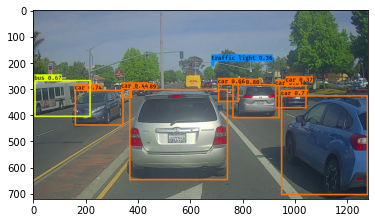

In [ ]:
out_scores, out_boxes, out_classes = predict("test.jpg")

**Expected Output**:

<table>
    <tr>
        <td>
            <b>Found 10 boxes for images/test.jpg</b>
        </td>
    </tr>
    <tr>
        <td>
            <b>car</b>
        </td>
        <td>
           0.89 (367, 300) (745, 648)
        </td>
    </tr>
    <tr>
        <td>
            <b>car</b>
        </td>
        <td>
           0.80 (761, 282) (942, 412)
        </td>
    </tr>
    <tr>
        <td>
            <b>car</b>
        </td>
        <td>
           0.74 (159, 303) (346, 440)
        </td>
    </tr>
    <tr>
        <td>
            <b>car</b>
        </td>
        <td>
          0.70 (947, 324) (1280, 705)
        </td>
    </tr>
    <tr>
        <td>
            <b>bus</b>
        </td>
        <td>
           0.67 (5, 266) (220, 407)
        </td>
    </tr>
    <tr>
        <td>
            <b>car</b>
        </td>
        <td>
           0.66 (706, 279) (786, 350)
        </td>
    </tr>
    <tr>
        <td>
            <b>car</b>
        </td>
        <td>
           0.60 (925, 285) (1045, 374)
        </td>
    </tr>
        <tr>
        <td>
            <b>car</b>
        </td>
        <td>
           0.44 (336, 296) (378, 335)
        </td>
    </tr>
    <tr>
        <td>
            <b>car</b>
        </td>
        <td>
           0.37 (965, 273) (1022, 292)
        </td>
    </tr>
    <tr>
        <td>
            <b>traffic light</b>
        </td>
        <td>
           00.36 (681, 195) (692, 214)
        </td>
    </tr>
</table>

The model you've just run is actually able to detect 80 different classes listed in "coco_classes.txt". To test the model on your own images:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the cell above code
    4. Run the code and see the output of the algorithm!

If you were to run your session in a for loop over all your images. Here's what you would get:

<center>
<video width="400" height="200" src="nb_images/pred_video_compressed2.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> Predictions of the YOLO model on pictures taken from a camera while driving around the Silicon Valley <br> Thanks to <a href="https://www.drive.ai/">drive.ai</a> for providing this dataset! </center></caption>

<a name='4'></a>
## 4 - Summary for YOLO

- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output. 
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers. 
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture. 
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and 80 is the number of classes we'd like to detect
- You then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output. 

<font color='blue'>
    
**What you should remember**:
    
- YOLO is a state-of-the-art object detection model that is fast and accurate
- It runs an input image through a CNN, which outputs a 19x19x5x85 dimensional volume. 
- The encoding can be seen as a grid where each of the 19x19 cells contains information about 5 boxes.
- You filter through all the boxes using non-max suppression. Specifically: 
    - Score thresholding on the probability of detecting a class to keep only accurate (high probability) boxes
    - Intersection over Union (IoU) thresholding to eliminate overlapping boxes
- Because training a YOLO model from randomly initialized weights is non-trivial and requires a large dataset as well as lot of computation, previously trained model parameters were used in this exercise. If you wish, you can also try fine-tuning the YOLO model with your own dataset, though this would be a fairly non-trivial exercise. 

**Congratulations!** You've come to the end of this assignment. 

Here's a quick recap of all you've accomplished.

You've: 

- Detected objects in a car detection dataset
- Implemented non-max suppression to achieve better accuracy
- Implemented intersection over union as a function of NMS
- Created usable bounding box tensors from the model's predictions

Amazing work! If you'd like to know more about the origins of these ideas, spend some time on the papers referenced below. 

<a name='5'></a>
## 5 - References

The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's GitHub repository. The pre-trained weights used in this exercise came from the official YOLO website. 
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 

### Car detection dataset

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The Drive.ai Sample Dataset</span> (provided by drive.ai) is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. Thanks to Brody Huval, Chih Hu and Rahul Patel for  providing this data. 